# NBA OYUNCULARININ İSTATİSTİKSEL ÖZELLİKLERİNE GÖRE POZİSYON TAHMİNİ

# ARKAPLAN ve MOTİVASYON
## Günümüzde birçok alanda (telefon alırken, araba alırken vs.) yaptığımız seçimleri teknik özelliklere, analiz göre yapıyoruz ama bazı alanlarda sadece hislerimizi, yapmak istediğimiz şeyleri düşünerek seçim yapıyoruz. Mesela bir mesleği seçerken bu mesleğe ne kadar uygun olduğumuza ne kadar dikkat ediyoruz? Biz de bu kapsamda değerlendirilebilecek bir konu olarak NBA oyuncularının istatistiklerine göre aslında hangi pozisyonda oynamaları gerektiği, hangi pozisyonlara daha yatkın olabileceğini konu edinen bir başlık seçtik.

# PROJENİN AMAÇLARI(PROBLEM TANIMI) 
## Bu projede NBA oyuncularının oynadıkları pozisyonların istatistiklere nasıl bir etkide bulunduğunu incelerken aynı zamanda oyuncu istatistiklerine göre oynadıkları pozisyonu makine öğrenmesi ile tahmin etmeye çalıştık. 
## Oyuncuların boy-kiloları, atış başarı oranları, asistleri vb. bir çok istatistiğin oyuncuların oynadığı pozisyonu etkiliyor mu?
## İstatistiklerini bildiğimiz bir oyuncunun pozisyonunu tahmin edebilir miyiz?
## Bir oyuncunun doğru pozisyonda oynayıp oynamadığını, o istatiklere göre diğer oyuncuların bilgilerini değerlendirmiş olacağız.

# VERİ 
## Veriler https://www.basketball-reference.com/players/ adresinden python kullanılarak alınmıştır. Veriler alınırken kullanılan kod aşağıda verilmiştir. Alınan veriler xlsx formatında excel tablosuna yazdırılmıştır.

# VERİ İŞLEME
## Alınan verilerde bazı oyuncular sakatlık durumunun olması, kontratının NBA'de olmasına rağmen başka ligde olduğu durumlarda oyuncular bu sezonda olmamıştır. Tabloda ilgili yerlerde "Did Not Play" yazmakta ve parantez içinde de neden oynamadığı, sakatlık türü gibi bilgiler bulunmaktaydı. Veriler bu oyunculardan arındırılmıştır. 
## Modern basketbolda eski basketbola bola göre oyun tarzı biraz daha değişti. Örneğin; pota altları da üçlük atmaya başladılar. Dolayısıyla oyun tarzının değişmesi güncel verilerin önemini daha da arttırmıştır. Bu yüzden verilerde 2013-14'den önceki sezona ait verilerden ayıklanmıştır.
## Verilerde oyuncuların boy değerleri feet-inch kilo değerleri lb cinsinden tutuluyordu. Verilerin feet-inch (2 ayrı birim)cinsinden verilmesi verinin işlenmesi anlamında daha sıkıntılı olabileceği için boy değerleri cm kilo değerleri kilogram cinsinde yazılmıştır.
## Oyuncular bazen oyun durumuna göre daha iyi oynadıkları yerden başka bir pozisyonda oynamak durumunda kalabilirler örneğin normalde center oynayan biri o sezon power forward da oynayabilir. Bu durumda verilerde position kısmında C-PF yazar. Ama oyuncunun oynadığı asıl poziyon center'dır. Bu yüzden verilerde sadece öncelikli pozisyon kalacak şekilde değiştirilmiştir.

In [2]:
#pandas ve numpy'ı import edelim ve excel dosyamızı yükleyelim.
import pandas as pd
import numpy as np

genel = pd.read_excel('veriseti.xlsx')

#2015-16 sezon öncesi istatistikleri data frame'den çıkaralım.
indexNames = genel[ genel['Season'] < "2013-14"].index
genel.drop(indexNames , inplace=True)

#Boş kısımları 0 ile doldurduk
genel.fillna(0,inplace=True)
#NaN değerleri attık
genel=genel.dropna()
#"Did Not Play" kısımlarını veri setimizden çıkaralım
genel2=genel['MP'].str.contains("Did Not Play")
genel3 = genel.loc[genel2.values==True].index
dataset = genel.drop(genel3)

#Basketbolcuların ağırlığı kilograma çevrildi
dataset['Weight(lb)'] = dataset['Weight(lb)'].map(lambda x: str(x)[:-2])
dataset['Weight(lb)'] = pd.to_numeric(dataset['Weight(lb)'], errors='coerce').fillna(0).astype(np.int64)
dataset['Weight(lb)'] = dataset['Weight(lb)']*0.45
dataset.rename(columns={'Weight(lb)': 'Weight(kg)'}, inplace=True)

#Basketbolcuların boyları santimetreye çevrildi
def changeToMetric(x):
    array=x.split("-")
    return int(array[0])*30.48+int(array[1])*2.54
dataset["Height(feet-inch)"]=dataset["Height(feet-inch)"].apply(changeToMetric)
dataset.rename(columns={'Height(feet-inch)': 'Height(cm)'}, inplace=True)

#İki pozisyonda oynayanların en çok oynadığı pozisyon alınır.
dataset['Pos'] = dataset['Pos'].map(lambda x: str(x)[0:2:1])
dataset = dataset.replace('C-','C')

#Feauturelar stringden floata çevrildi
col_list = dataset.columns[4:-1]
for item in col_list:
    dataset[item] = pd.to_numeric(dataset[item], errors='coerce').fillna(0).astype(np.float64)

#PG = 1 Point Guard
#SG = 2 Shooting Guard
#SF = 3 Small Forward
#PF = 4 Power Forward
#C = 5 Center

dataset.head(20)


,İsim,Season,Tm,Lg,Height(cm),Weight(kg),2P,2P%,2PA,3P,...,GS,MP,ORB,PF,PTS,STL,TOV,TRB,eFG%,Pos
0,Alex Abrines,2016-17,OKC,NBA,198.12,90.00,0.6,0.426,1.4,1.4,...,6.0,15.5,0.3,1.7,6.0,0.5,0.5,1.3,0.531,SG
1,Alex Abrines,2017-18,OKC,NBA,198.12,90.00,0.4,0.443,0.9,1.1,...,8.0,15.1,0.3,1.7,4.7,0.5,0.3,1.5,0.540,SG
2,Alex Abrines,2018-19,OKC,NBA,198.12,90.00,0.5,0.500,1.0,1.3,...,2.0,19.0,0.2,1.7,5.3,0.5,0.5,1.5,0.487,SG
4,Quincy Acy,2013-14,TOT,NBA,200.66,108.00,1.0,0.492,2.0,0.1,...,0.0,13.4,1.1,1.9,2.7,0.4,0.5,3.4,0.482,SF
5,Quincy Acy,2013-14,TOR,NBA,200.66,108.00,0.6,0.444,1.3,0.3,...,0.0,8.7,0.7,1.1,2.7,0.6,0.3,2.1,0.500,SF
6,Quincy Acy,2013-14,SAC,NBA,200.66,108.00,1.0,0.496,2.1,0.0,...,0.0,14.0,1.2,2.0,2.7,0.3,0.5,3.6,0.480,SF
7,Quincy Acy,2014-15,NYK,NBA,200.66,108.00,2.0,0.494,4.0,0.3,...,22.0,18.9,1.2,2.2,5.9,0.4,0.9,4.4,0.486,PF
8,Quincy Acy,2015-16,SAC,NBA,200.66,108.00,1.7,0.606,2.8,0.3,...,29.0,14.8,1.1,1.7,5.2,0.5,0.5,3.2,0.600,PF
9,Quincy Acy,2016-17,TOT,NBA,200.66,108.00,0.9,0.413,2.1,1.0,...,1.0,14.7,0.5,1.8,5.8,0.4,0.6,3.0,0.521,PF
10,Quincy Acy,2016-17,DAL,NBA,200.66,108.00,0.7,0.400,1.7,0.2,...,0.0,8.0,0.3,1.5,2.2,0.0,0.3,1.3,0.324,PF


In [3]:
dataset.shape

(3091, 33)

# KEŞİF ANALİZİ
## Verilerimizi görselleştirmek için pasta grafiği, sütun grafiği, dağılım grafiği çizdik. 
## Pasta grafiği çizmek için matplotlib.pyplot kütüphanesinde pie yöntemi, sütun grafiği çizmek için matplotlib.pyplot kütüphanesinde plot yöntemini, dağılım grafiği çizmek için matplotlib.pyplot kütüphanesinden scatter yöntemini dataframeler üzerinde kullandık.

## Pozisyonlara Göre Oyuncu Sayısı Dağılımı 

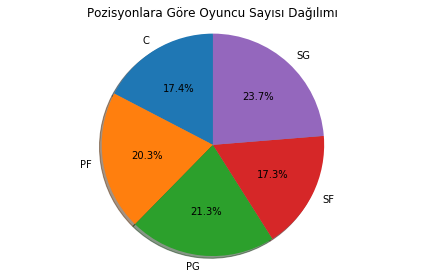

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

pos_count = dataset.groupby('Pos').size().reset_index(name='Toplam Oynayan')
pos_count.set_index('Pos', inplace = True)

labels = pos_count.index
sizes = pos_count["Toplam Oynayan"].values
explode = (0, 0, 0, 0, 0)  

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
               shadow=True, startangle=90)
plt.title("Pozisyonlara Göre Oyuncu Sayısı Dağılımı")
ax1.axis('equal')  
plt.tight_layout()
plt.show()

## Pozisyonların En Başarılı Olduğu Alanlar

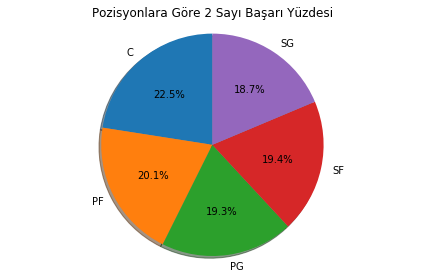

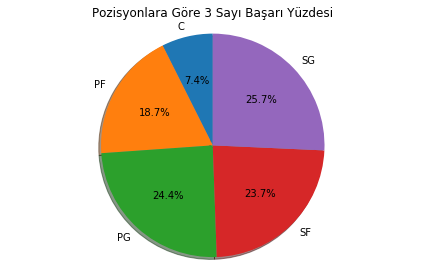

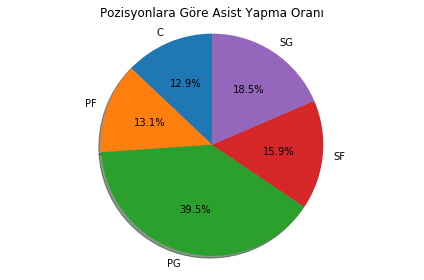

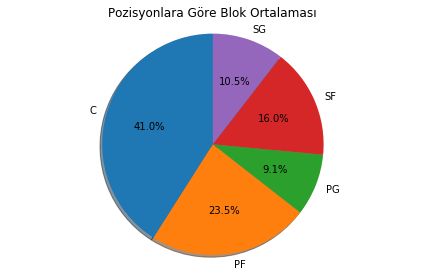

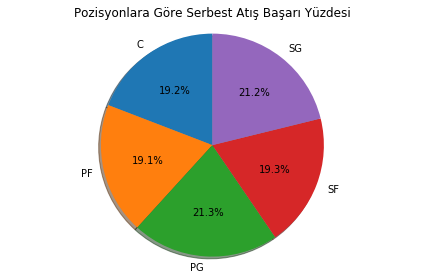

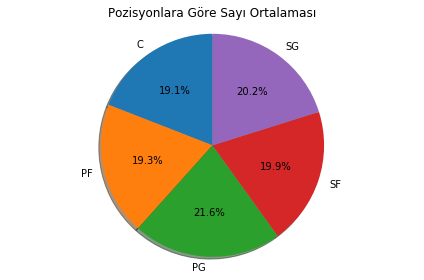

In [5]:
can_do_best = dataset[['2P%','3P%','AST','BLK','FT%','PTS','Pos']]
can_do_best = can_do_best.groupby('Pos').mean()
##########################
labels = can_do_best.index
sizes = can_do_best["2P%"].values
explode = (0, 0, 0, 0, 0)  

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
               shadow=True, startangle=90)
plt.title("Pozisyonlara Göre 2 Sayı Başarı Yüzdesi")
ax1.axis('equal')  
plt.tight_layout()
plt.show()
##########################
sizes = can_do_best["3P%"].values

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
               shadow=True, startangle=90)
plt.title("Pozisyonlara Göre 3 Sayı Başarı Yüzdesi")
ax1.axis('equal')  
plt.tight_layout()
plt.show()
##########################
sizes = can_do_best["AST"].values

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
               shadow=True, startangle=90)
plt.title("Pozisyonlara Göre Asist Yapma Oranı")
ax1.axis('equal')  
plt.tight_layout()
plt.show()
##########################
sizes = can_do_best["BLK"].values

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
               shadow=True, startangle=90)
plt.title("Pozisyonlara Göre Blok Ortalaması")
ax1.axis('equal')  
plt.tight_layout()
plt.show()
##########################
sizes = can_do_best["FT%"].values

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
               shadow=True, startangle=90)
plt.title("Pozisyonlara Göre Serbest Atış Başarı Yüzdesi")
ax1.axis('equal')  
plt.tight_layout()
plt.show()
##########################
sizes = can_do_best["PTS"].values

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
               shadow=True, startangle=90)
plt.title("Pozisyonlara Göre Sayı Ortalaması")
ax1.axis('equal')  
plt.tight_layout()
plt.show()

## Pozisyonlara Göre 2 Sayı Ortalaması

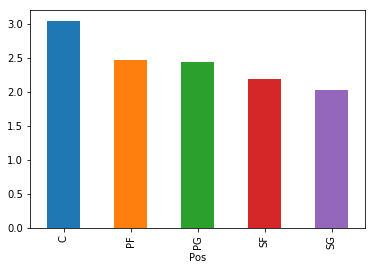

In [6]:
dataset.groupby('Pos')['2P'].mean().plot(kind="bar")

## Pozisyonlara Göre 3 Sayı Ortalaması

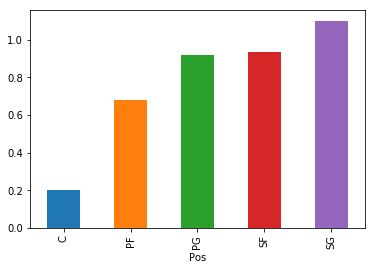

In [7]:
dataset.groupby('Pos')['3P'].mean().plot(kind="bar")


## Pozisyonlara Göre Boy Dağılımı

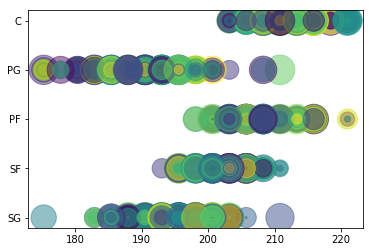

In [8]:
boy = dataset['Height(cm)'].values
pos = dataset['Pos']
N = 50
colors = np.random.rand(3091)
area = (30 * np.random.rand(N))**2  #yuvarlakların boyutu

plt.scatter(boy, pos, s=area, c=colors, alpha=0.5)
plt.show()

## Pozisyonlara Göre Kilo Dağılımı

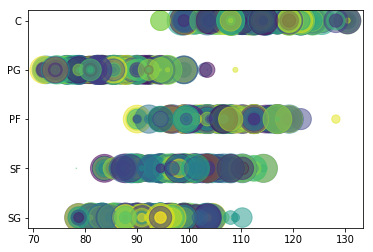

In [9]:
kilo = dataset['Weight(kg)'].values
pos = dataset['Pos']
N = 50
colors = np.random.rand(3091)
area = (30 * np.random.rand(N))**2 #yuvarlakların boyutu

plt.scatter(kilo, pos, s=area, c=colors, alpha=0.5)
plt.show()

# ANALİZ METODOLOJİSİ

# Decision Tree Classifier
### Karar Ağaçları (DT), sınıflandırma ve regresyon için kullanılan parametrik olmayan, denetimli bir öğrenme yöntemidir. Amaç, veri özelliklerinden elde edilen basit karar kurallarını öğrenerek bir hedef değişkenin değerini tahmin eden bir model oluşturmaktır.

In [10]:
from sklearn import datasets 
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

X = dataset[dataset.columns[4:-1]]
y = dataset[dataset.columns[-1]]
 # dividing X, y into train and test data 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0) 

kf= KFold(10,True,1)

# training a DecisionTreeClassifier 
from sklearn.tree import DecisionTreeClassifier 
dtree_model = DecisionTreeClassifier().fit(X_train, y_train) 

  
cv_results4 = cross_val_score(dtree_model, # Pipeline
                             X, # Feature matrix
                             y, # Target vector
                             cv=kf, # Cross-validation technique
                             scoring="accuracy", # Loss function
                             )
decision_predictions=dtree_model.predict(X_test)
print("Tahminleme başarı oranları: ")
print(cv_results4*100)
print("Ortalama tahminleme başarı oranı: ")
cv_results4.mean()*100

Tahminleme başarı oranları: 
[78.70967742 77.66990291 77.02265372 76.69902913 78.3171521  73.78640777
 75.08090615 77.02265372 75.08090615 79.61165049]
Ortalama tahminleme başarı oranı: 


76.90009395552771

##  KNN'ye Göre Tahminleme
### Gözetimli öğrenme metotlarından sınıflandırma (classification) işleminde kullanılan K-KN (K-Nearest Neighborhood, En Yakın K Komşu) algoritmasıdır. KNN algoritması bir eğitim verisi içerir. Yeni bir değer geldiğinde K değerine mesafeler hesaplanır ve yeni değer bir kümeye ilave edilir.

In [11]:
from sklearn.neighbors import KNeighborsClassifier

#KNN'ye Göre Tahminleme
knn = KNeighborsClassifier(n_neighbors = 5,).fit(X_train, y_train) 

cv_results = cross_val_score(knn, # Pipeline
                             X, # Feature matrix
                             y, # Target vector
                             cv=kf, # Cross-validation technique
                             scoring="accuracy", # Loss function
                            )
knn_predictions=knn.predict(X_test)
print("Tahminleme başarı oranları: ")
print(cv_results*100)
print("Ortalama tahminleme başarı oranı: ")
cv_results.mean()*100

Tahminleme başarı oranları: 
[64.83870968 67.63754045 65.69579288 66.99029126 67.31391586 67.96116505
 70.55016181 66.66666667 63.43042071 70.87378641]
Ortalama tahminleme başarı oranı: 


67.1958450777743

## Lineer SVM Model İçin Tahminleme
### Sınıflandırma için bir düzlemde bulunan iki grup arasında bir sınır çizilerek iki grubu ayırmak mümkündür. Bu sınırın çizileceği yer ise iki grubun da üyelerine en uzak olan yer olmalıdır. İşte SVM bu sınırın nasıl çizileceğini belirler.

In [12]:
from sklearn.svm import SVC 
from sklearn.model_selection import cross_val_score

#Lineer SVM Model İçin Tahminleme
svm_model_linear = SVC(kernel = 'linear', C = 1.2).fit(X_train, y_train) 

  
cv_results2 = cross_val_score(svm_model_linear, # Pipeline
                             X, # Feature matrix
                             y, # Target vector
                             cv=kf, # Cross-validation technique
                             scoring="accuracy", # Loss function
                             )

svm_predictions = svm_model_linear.predict(X_test) 
print("Tahminleme başarı oranları: ")
print(cv_results2*100)
print("Ortalama tahminleme başarı oranı: ")
cv_results2.mean()*100

Tahminleme başarı oranları: 
[78.70967742 83.49514563 82.84789644 80.90614887 80.58252427 79.93527508
 78.6407767  77.99352751 76.69902913 79.28802589]
Ortalama tahminleme başarı oranı: 


79.9098026933918

## Logistic Regression ile Tahminleme
### Logistic Regression genellikle evet-hayır sorularına cevap bulmak için kullanılan bir algoritmadır. Lojistik regresyon, bağımlı değişken ikilik olduğunda (ikili) olduğunda yapılması gereken uygun regresyon analizidir. Verileri tanımlamak ve bir bağımlı ikili değişken ile bir veya daha fazla nominal, sıra, aralık veya oran düzeyinde bağımsız değişkenler arasındaki ilişkiyi açıklamak için lojistik regresyon kullanılır. Her ne kadar bu verisetine uygun olamayacağı düşünülse de nasıl bir sonuç ortaya çıkacağını görmek için bu yöntem de kullanılmıştır.

In [13]:
#Logistic Regression ile Tahminleme
from sklearn.linear_model import LogisticRegression

from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

logit = LogisticRegression().fit(X_train, y_train) 
cv_results3 = cross_val_score(logit, # Pipeline
                             X, # Feature matrix
                             y, # Target vector
                             cv=kf, # Cross-validation technique
                             scoring="accuracy", # Loss function
                             )
logistic_predictions=logit.predict(X_test)
print("Tahminleme başarı oranları: ")
print(cv_results3*100)
print("Ortalama tahminleme başarı oranı: ")
cv_results3.mean()*100

Tahminleme başarı oranları: 
[69.35483871 69.57928803 69.25566343 69.90291262 66.34304207 66.34304207
 66.99029126 66.01941748 61.81229773 62.78317152]
Ortalama tahminleme başarı oranı: 


66.83839649232696

# ANALİZ SONUÇLARI

##  Yöntemlerine Göre Ortalama Tahminler
### Her tahminlemede cross-validation tekniği kullanılmıştır ve 10 tane ayrı tahminleme değerleri ortaya çıkmıştır. Her tahminleme yöntemi için bu değerlerin ortalaması alınarak görselleştirilmiştir.

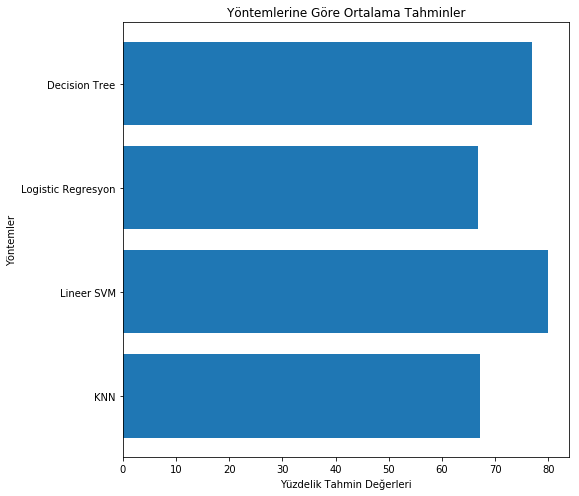

In [14]:
plt.figure(figsize=(8,8))
y_ortalamalar = [cv_results.mean()*100,cv_results2.mean()*100,cv_results3.mean()*100,cv_results4.mean()*100]
x_yontemler_array = ['KNN','Lineer SVM','Logistic Regresyon','Decision Tree']
x_yontemler = np.arange(len(y_ortalamalar))

plt.barh(x_yontemler,y_ortalamalar)
plt.title("Yöntemlerine Göre Ortalama Tahminler")
plt.yticks(x_yontemler,x_yontemler_array);

plt.ylabel("Yöntemler")
plt.xlabel("Yüzdelik Tahmin Değerleri")

plt.show();

## Yöntemlerine Göre En Düşük ve En Yüksek Tahminler
### Cross-validation tekniğine göre ortaya çıkan tahminlerden en iyi ve en kötü tahminleme oranları alınarak tahminleme yöntemlerine göre görselleştirilmiştir.

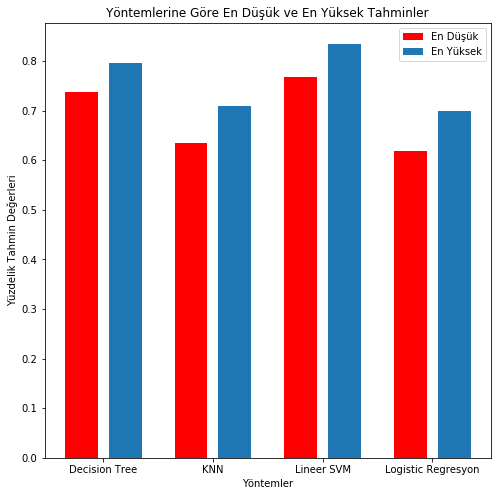

In [15]:
plt.figure(figsize=(8,8))
min_max_y_1 = [cv_results4.min(),cv_results.min(),cv_results2.min(),cv_results3.min()]
min_max_y_2 = [cv_results4.max(),cv_results.max(),cv_results2.max(),cv_results3.max()]
x_yontemler_array = ['Decision Tree','KNN','Lineer SVM','Logistic Regresyon']
x_yontemler = np.arange(len(min_max_y_1))


plt.bar(x_yontemler-0.2,min_max_y_1,color="r",width=0.3)
plt.bar(x_yontemler+0.2,min_max_y_2,width=0.3)


plt.title("Yöntemlerine Göre En Düşük ve En Yüksek Tahminler")

plt.xticks(x_yontemler,x_yontemler_array);

plt.xlabel("Yöntemler")
plt.ylabel("Yüzdelik Tahmin Değerleri")

plt.legend(["En Düşük","En Yüksek"])
plt.show();

## Yöntemlere ve Poziyonlara Göre Başarı Oranlarının Sütun Grafikleri

In [16]:
tum_oranlar = [] #yöntemlere ve pozisyona göre tüm ortalama oranları tutacak olan array
for y in [svm_predictions,knn_predictions,decision_predictions,logistic_predictions]:
    oranlar = []
    for x in ['C','PF','PG','SF','SG']:
        tahminim = [index for index, value in enumerate(y) if value == x] #Tahmin edilen PF sayısı
        cevaplarim = [index for index, value in enumerate(y_test) if value == x] #Gerçekteki PF sayısı (indexleri)
        oranim = len(set(tahminim) & set(cevaplarim))/len(tahminim)*100
        oranlar.append(oranim)
    tum_oranlar.append(oranlar)
    
x_pos_array = ['C','PF','PG','SF','SG']

### Lineer SVM Model Tahmini İle Pozisyon Tahmin Başarı Oranları

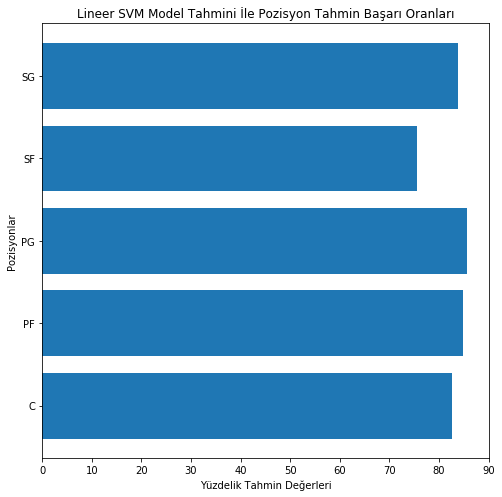

In [17]:
plt.figure(figsize=(8,8))
x_positions0 = np.arange(len(tum_oranlar[0]))
plt.barh(x_positions0,tum_oranlar[0])
plt.title("Lineer SVM Model Tahmini İle Pozisyon Tahmin Başarı Oranları")
plt.yticks(x_positions0,x_pos_array);
plt.ylabel("Pozisyonlar")
plt.xlabel("Yüzdelik Tahmin Değerleri")
plt.show();

### KNN'ye Göre Tahminleme İle Pozisyon Tahmin Başarı Oranları

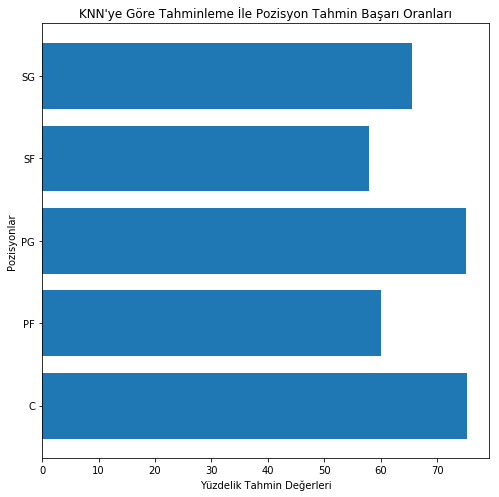

In [18]:
plt.figure(figsize=(8,8))
x_positions1 = np.arange(len(tum_oranlar[1]))
plt.barh(x_positions1,tum_oranlar[1])
plt.title("KNN'ye Göre Tahminleme İle Pozisyon Tahmin Başarı Oranları")
plt.yticks(x_positions1,x_pos_array);
plt.ylabel("Pozisyonlar")
plt.xlabel("Yüzdelik Tahmin Değerleri")
plt.show();

### Decision Tree Classifier Yöntemi İle Pozisyon Tahmin Başarı Oranları

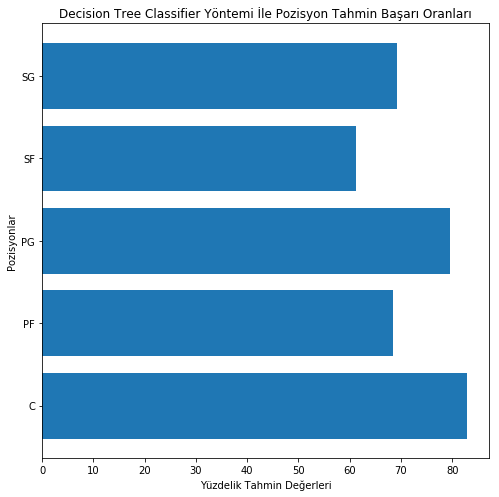

In [19]:
plt.figure(figsize=(8,8))
x_positions2 = np.arange(len(tum_oranlar[2]))
plt.barh(x_positions2,tum_oranlar[2])
plt.title("Decision Tree Classifier Yöntemi İle Pozisyon Tahmin Başarı Oranları")
plt.yticks(x_positions2,x_pos_array);
plt.ylabel("Pozisyonlar")
plt.xlabel("Yüzdelik Tahmin Değerleri")
plt.show();

### Logistic Regression Tahminleme İle Pozisyon Tahmin Başarı Oranları

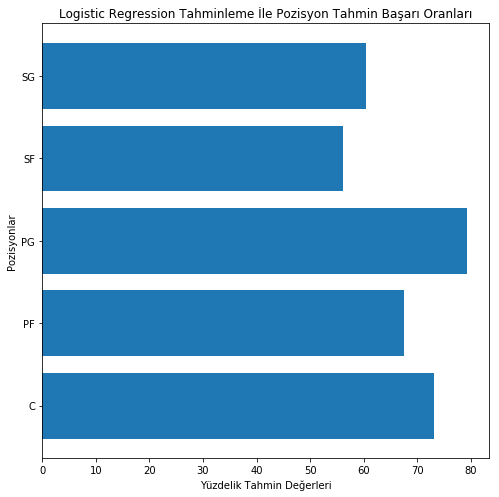

In [20]:
plt.figure(figsize=(8,8))
x_positions3 = np.arange(len(tum_oranlar[3]))
plt.barh(x_positions3,tum_oranlar[3])
plt.title("Logistic Regression Tahminleme İle Pozisyon Tahmin Başarı Oranları")
plt.yticks(x_positions3,x_pos_array);
plt.ylabel("Pozisyonlar")
plt.xlabel("Yüzdelik Tahmin Değerleri")
plt.show();

## Örnek Predict

In [21]:
michael_jordan = [[198,88,8.1,0.45,18,0.2,0.291,0.7,3.8,39,0.5,5.2,8.3,0.445,18.6,3.2,0.821,4.0,82,67,37,0.9,2.1,20,1.5,2.1,6.1,0.450]]
np.reshape(michael_jordan, (1, -1))
custom_predict = svm_model_linear.predict(michael_jordan)
custom_predict

array(['SG'], dtype=object)

### Michael Jordan oynadığı 15 sezonun 13 sezonunda SG 2 sezonunda SF oynamıştır. Son sezon istatistikleri girilerek Michael Jordan'ın SG pozisyonunda oynadığı tahmin edilmiştir.

# İŞ BÖLÜMÜ

## Ağırlıklı olarak Selman Trabzon Python ile veri çekme konusunda; Taner Şahin verilerin görselleştirilmesi, temizlenmesi, analizi; Ahmet Hakan Uzun verilerin temizlenmesi ve tahminlenmesi konularında uğraşmışlardır. Grup üyeleri projenin tamamını buluşarak birlikte yapmışlardır.

### 05150000643 - Taner Şahin
### 05160000295 - Ahmet Hakan Uzun
### 05160000109 - Selman Trabzon